# **Анализ маркетинговых метрик и результатов A/В теста для мобильного приложения по продаже продуктов питания**

## **Цели исследования**

+ Изучить поведение пользователей мобильного приложения, проанализировать воронку продаж, узнать, как пользователи доходят до покупки. 
+ Выяснить, сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах и на каких именно
+ Исследовать результаты A/A/B-эксперимента

## **Краткое описание проекта и план работ**

Руководство стартапа, который продаёт продукты питания, поставило задачу изучить воронку продаж и разобраться, как ведут себя пользователи мобильного приложения.

Кроме того, необходимо исследовать результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всем приложении, однако окончательное решение по поводу их внедрения договорились принять по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Нужно выяснить, какой шрифт лучше.

**Описание данных**

Датасет содержит информацию о действиях пользователей в приложении. Описание столбцов:

+ EventName — название события;
+ DeviceIDHash — уникальный идентификатор пользователя;
+ EventTimestamp — время события;
+ ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

**План работ**

+ Исследовать данные, представленные в датасете: за какой период данные представлены, есть ли дубликаты, пропуски, аномальные значения, как распределены наблюдения по группам и т.д.
+ Построить и изучить воронку продаж, определить, сколько пользователей доходит до покупки, а сколько "застревает" на предыдущих шагах.
+ Проанализировать результаты A/A/B-теста. Выяснить, корректно ли распределены пользователи по контрольным группами. Провести статистическую оценку различий маркетинговых метрик в контрольных группах, и отдельно в каждой из контрольных групп и экспериментальной группе.



## **1. Загрузка данных**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
import matplotlib.pyplot as plt

In [3]:
from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest
import math as mth
import datetime as dt

In [4]:
sns.set()

In [7]:
logs = pd.read_csv('C:/Rabota/IT/Datasets/final2/logs_exp.csv', sep='\t')

In [8]:
logs.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


## **2. Подготовка данных**

### **2.1. Общая информация. Пропуски и дубликаты**

In [9]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [10]:
logs.duplicated().sum()

413

Датасет содержит информацию о действиях пользователей в приложении. Всего в датасете 244126 строки и 4 столбца. 
Описание столбцов:
+ EventName — название события;
+ DeviceIDHash — уникальный идентификатор пользователя;
+ EventTimestamp — время события;
+ ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

Пропуски в датасете отсутствуют, однако есть дубликаты, от которых нужно избавиться.

In [11]:
logs = logs.drop_duplicates()

### **2.2. Названия столбцов. Формат данных**

Приведем названия столбцов к эталонному виду

In [12]:
logs.columns = ['event_name', 'device_id_hash', 'event_timestamp', 'exp_id']

Поменяем формат столбца с датами с object на datetime, имея в виду, что все даты в столбце у нас указаны в формате unix time.

In [13]:
logs['event_timestamp'] = pd.to_datetime(logs['event_timestamp'], unit='s')

Создадим отдельный столбец с датой в формате YYYY-MM-DD

In [14]:
logs['dt'] = logs['event_timestamp'].dt.date

In [15]:
logs['dt'] = pd.to_datetime(logs['dt'], format='%Y-%m-%d')

In [16]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   device_id_hash   243713 non-null  int64         
 2   event_timestamp  243713 non-null  datetime64[ns]
 3   exp_id           243713 non-null  int64         
 4   dt               243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 11.2+ MB


## **3. Предварительный анализ данных**

### **3.1 Сколько всего событий в логе**

In [17]:
logs.event_name.value_counts(normalize=True, ascending=False)

MainScreenAppear           0.488694
OffersScreenAppear         0.192062
CartScreenAppear           0.175075
PaymentScreenSuccessful    0.139993
Tutorial                   0.004177
Name: event_name, dtype: float64

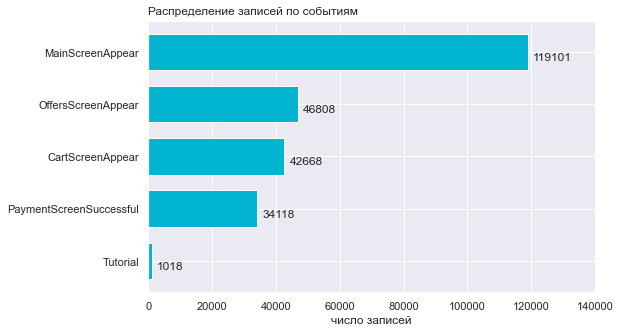

In [18]:
fig, ax = plt.subplots(figsize=(8,5))
logs.event_name.value_counts(ascending=True).plot(kind='barh', color='#00B4D2', width=0.7)

for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y() + 0.0),
                xytext=(5, 10), textcoords='offset points')
    
plt.title("Распределение записей по событиям", loc='left')
plt.xlabel("число записей")
plt.xlim(0,140000);

Всего у нас пять событий: показ пользователю главного экрана, показ экрана с предложением, показ экрана с корзиной, показ экрана об успешной оплате и экрана с обучением. Судя по статистике, опция с обучением не пользуется популярностью у пользователей и явно не является обязательной - на ее долю приходится меньше половины процента всех записей. Чаще всего в датасете фигугирует показ главного экрана (почти половина всех наблюдений), что вполне логично, поскольку именно главный экран в большинстве случаев является стартовой площадкой для дальнейшего перемещения пользователя по приложению.

### **3.2. Сколько в среднем событий приходится на пользователя**

In [19]:
# Сколько в среднем уникальных событий приходится на пользователя
logs.groupby('device_id_hash')['event_name'].agg('nunique').mean()

2.6744802012978415

In [20]:
# Сколько в среднем всех событий приходится на пользователя
logs.groupby('device_id_hash')['event_name'].agg('count').mean()

32.27559263673685

Мы видим, что на одного пользователя в среднем приходится 2,7 уникальных события. Грубо говоря, это значит, что пользователи в среднем, как минимум, открывают главную страницу и, к примеру, переходят на страницу с предложением. При этом повторяющихся событий на каждого пользователя приходится в среднем 32. 

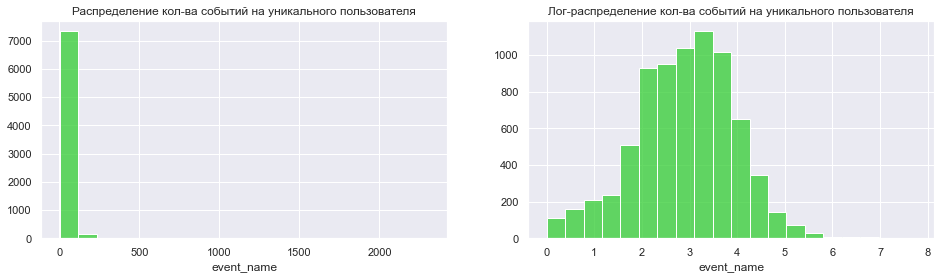

In [21]:
user_activity = logs.groupby('device_id_hash')['event_name'].agg('count').reset_index()

fig, ax = plt.subplots(1,2,figsize=(16,4))
sns.histplot(user_activity.event_name, kde=False, color="limegreen", ax=ax[0], bins=20)
sns.histplot(np.log(user_activity.event_name), ax=ax[1], bins=20, color="limegreen", kde=False)
ax[0].set_title("Распределение кол-ва событий на уникального пользователя")
ax[1].set_title("Лог-распределение кол-ва событий на уникального пользователя")
ax[0].set_ylabel('')
ax[1].set_ylabel('');

In [22]:
np.exp(5.7)

298.8674009670603

In [23]:
np.exp(3.2)

24.532530197109352

In [24]:
(user_activity['event_name'] < 300).mean()

0.9957621507085155

По графику видно, что распределение событий сильно перекошено и близко к логнормальному. У 99,6% пользователей кол-во событий не превышает 300, а в среднем находится в районе 24. При этом есть единичные выбросы, доходящие до 2000 событий и более.

Посмотрим на точечном графике, как распределяются данные о кол-ве событий на каждого пользователя между разными группами.

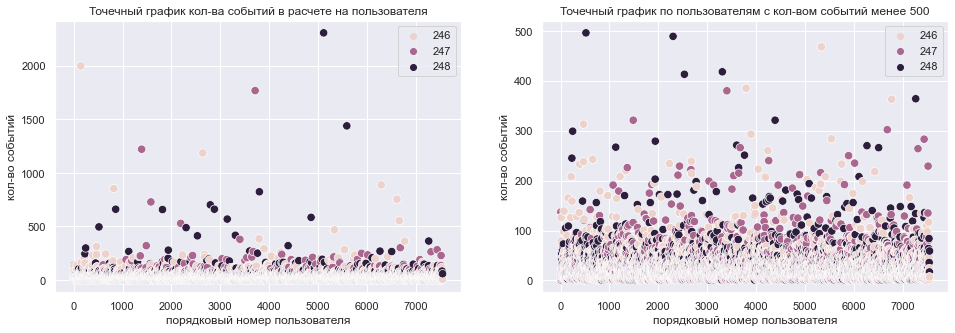

In [25]:
# Создадим переменную events_per_user с данными о кол-ве событий, сгруппированными по пользователям и группам
events_per_user = logs.groupby(['device_id_hash', 'exp_id'])['event_name'].agg('count').reset_index()

# Посмотрим два точечных графика: со всеми событиями и укрупненный график с пользователями, совершившими не более 500 событий
fig, ax = plt.subplots(1,2, figsize=(16,5))
sns.scatterplot(x=events_per_user.index, y=events_per_user['event_name'], hue=events_per_user['exp_id'], ax=ax[0], s=70)
sns.scatterplot(x=events_per_user.query('event_name < 500').index, \
                y=events_per_user.query('event_name < 500')['event_name'], \
                hue=events_per_user.query('event_name < 500')['exp_id'], ax=ax[1], s=70)
ax[0].set_xlabel('порядковый номер пользователя')
ax[1].set_xlabel('порядковый номер пользователя')
ax[0].set_ylabel('кол-во событий')
ax[1].set_ylabel('кол-во событий')
ax[0].legend()
ax[1].legend()
ax[0].set_title("Точечный график кол-ва событий в расчете на пользователя")
ax[1].set_title("Точечный график по пользователям с кол-вом событий менее 500");

На первом графике хорошо видны единичные выбросы, причем аномальных выбросов явно больше в тестовой группе 248 и чуть меньше в контрольных группах 246 и 247. Это может исказить результаты анализа A/В теста, поэтому от аномальных выбросов целесообразно будет избавиться на этапе фильтрации данных. За уровень отсечки возьмем 300 событий на пользователя. Как мы выяснили выше, потеря в данных при такой фильтрации составит менее 0,5%.

In [26]:
# Создадим переменную abnomal_users с id пользователей, совершивших 300 событий и более, для последующей фильтрации
abnormal_users = events_per_user.query('event_name >=300')['device_id_hash'].values

### **3.3. Сколько всего пользователей в логе**

In [27]:
# Подсчитаем число уникальных пользователей
logs.device_id_hash.nunique()

7551

Проверим, чтобы у нас не было пересечений по уникальным пользователям между группами.

In [28]:
logs.groupby('device_id_hash')['exp_id'].agg('nunique').sort_values(ascending=False)

device_id_hash
6888746892508752       1
6207768971558512760    1
6217807653094995999    1
6217295124800833842    1
6216080220799726690    1
                      ..
3175239243679501019    1
3171891164497446149    1
3171454373076660766    1
3170212200647575044    1
9222603179720523844    1
Name: exp_id, Length: 7551, dtype: int64

У нас нет пользователей, попавших сразу в несколько групп. Теперь посмотрим, как распределены пользователи между группами.

In [29]:
logs.groupby('exp_id')['device_id_hash'].agg('nunique')

exp_id
246    2489
247    2520
248    2542
Name: device_id_hash, dtype: int64

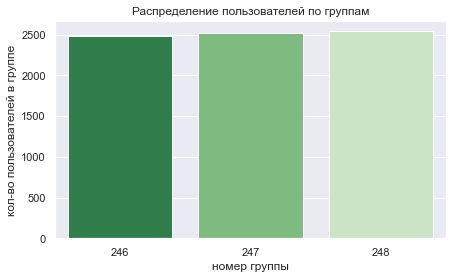

In [30]:
groups = logs.groupby('exp_id')['device_id_hash'].agg('nunique')

fig, ax = plt.subplots(figsize=(7,4))

sns.barplot(x=groups.index, y=groups.values, palette="Greens_r")
plt.title("Распределение пользователей по группам")
plt.xlabel("номер группы")
plt.ylabel("кол-во пользователей в группе");

В целом, распределение довольно равномерное. Есть небольшая разница между двумя контрольными группами (246 и 247): в первой 2489 человек, во второй несколько больше - 2520 человек. Больше всего пользователей в тестовой группе 248 - 2542 человека. 

### **3.4. Данными за какой период мы располагаем** 

In [31]:
logs.event_timestamp.apply(['min', 'max']).reset_index()

,index,event_timestamp
0,min,2019-07-25 04:43:36
1,max,2019-08-07 21:15:17


Самые ранние записи относятся к 25 июля 2019 года, самые поздние - к 7 августа 2019 года, т.е. у нас данные за полные две недели. Проверим, как распределяются записи по датам.

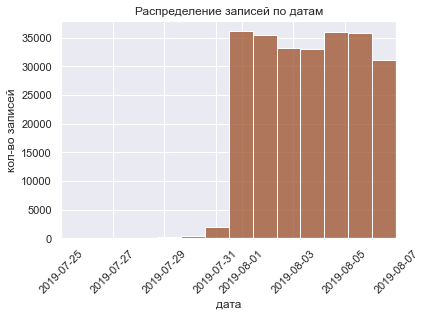

In [32]:
sns.histplot(logs['dt'], bins=14, color='#9B5028')
plt.xlim(dt.datetime(2019, 7, 25), dt.datetime(2019, 8, 7))
plt.title("Распределение записей по датам")
plt.xlabel('дата')
plt.ylabel('кол-во записей')
plt.xticks(rotation=45);

In [33]:
(logs['dt'] > "2019-07-31").mean()

0.988404393692581

Мы видим, что по времени записи распределены крайне неравномерно. Наиболее полные данные, пригодные к анализу, у нас имеются с 1 августа, то есть за одну неделю. На этот период приходится почти 99% всех наблюдений. Более ранние записи необходимо исключить из анализа как неполные и непригодные для сравнительных исследований.

In [34]:
df = logs.query('dt > "2019-07-31"')

Проверим, сколько событий и пользователей мы потеряли, отбросив старые данные.

In [35]:
# Сколько уникальных пользователей в отфильтрованном датафрейме
df.device_id_hash.nunique()

7534

In [36]:
# Сколько уникальных пользователей мы потеряли при фильтрации
logs.device_id_hash.nunique() - df.device_id_hash.nunique()

17

In [37]:
# Сколько событий мы потеряли
logs.event_name.count() - df.event_name.count()

2826

При фильтрации мы "потеряли" всего 17 уникальных пользователей (это менее одного процента от общего числа) и примерно 2800 событий (около 1% от общего числа). 

Удалим также аномальных пользователей, совершивших 300 и более событий.

In [38]:
df = df[~df['device_id_hash'].isin(abnormal_users)]

Проверим распределение пользователей по группам после фильтрации. 

In [39]:
df.groupby('exp_id')['device_id_hash'].agg('nunique')

exp_id
246    2474
247    2506
248    2522
Name: device_id_hash, dtype: int64

Text(0, 0.5, 'кол-во пользователей в группе')

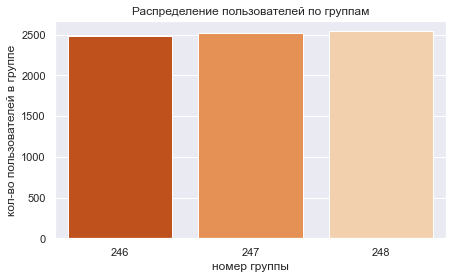

In [40]:
df_groups = df.groupby('exp_id')['device_id_hash'].agg('nunique')

fig, ax = plt.subplots(figsize=(7,4))

sns.barplot(x=groups.index, y=groups.values, palette="Oranges_r")
plt.title("Распределение пользователей по группам")
plt.xlabel("номер группы")
plt.ylabel("кол-во пользователей в группе")

На распределении пользователей по группам фильтрация особо не сказалась: группы по-прежнему примерно одинаковые.

## **4. Воронка событий**

### **4.1. Частота появления событий в логах**

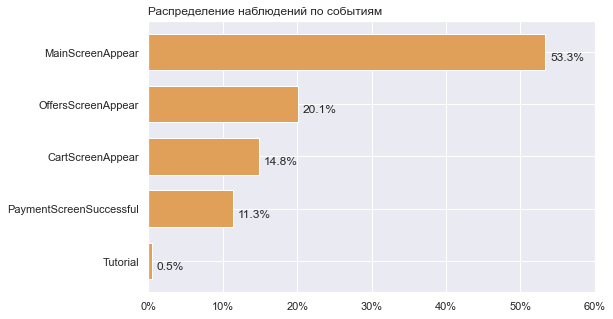

In [98]:
# Визуализируем, как распределяются записи по событиям в датасете
fig, ax = plt.subplots(figsize=(8,5))
df.event_name.value_counts(normalize=True, ascending=True).plot(kind='barh', color='#E1A05A', width=0.7)

for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_width()), (p.get_x() + p.get_width(), p.get_y() + 0.0),
                xytext=(5, 10), textcoords='offset points')
    ax.set_xticks(ax.get_xticks().tolist())
    _ = ax.set_xticklabels(map('{:.0f}%'.format, 100*ax.xaxis.get_majorticklocs()))
    
plt.title("Распределение наблюдений по событиям", loc='left')
plt.xlim(0,0.6);

Наиболее часто в логах появляются записи о показе пользователям главного экрана - на них приходится более половины всех наблюдений (53,3%). На втором месте - экран с предложением (20.1%) и далее с небольшим отрывом идет экран с корзиной (14,8%). Примерно 11.3% записей посвящены успешным платежам и, наконец, реже всего фигурирует экран с обучением (0,5%). Судя по всему, подавляющая часть пользователей достачно уверенно чувствует себя в приложении и не ощущает необходимость в дополнительных разъяснениях. 

### **4.2. Сколько пользователей совершает какое событие**

Подсчитаем, сколько уникальных пользователей совершали каждое из событий и долю пользователей, которые хоть раз совершали событие.

In [42]:
# Сколько уникальных пользователей совершали каждое событие
df.groupby('event_name')['device_id_hash'].agg('nunique').sort_values(ascending=False)

event_name
MainScreenAppear           7387
OffersScreenAppear         4561
CartScreenAppear           3702
PaymentScreenSuccessful    3507
Tutorial                    835
Name: device_id_hash, dtype: int64

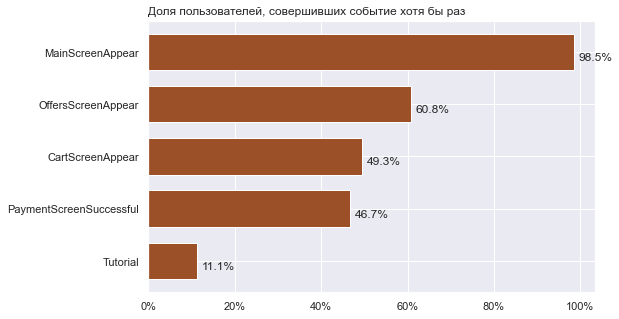

In [96]:
fig, ax = plt.subplots(figsize=(8,5))
(
    df.groupby('event_name')['device_id_hash'] .agg('nunique')
    .apply(lambda x: x/df.device_id_hash.nunique())
    .sort_values(ascending=True).plot(kind='barh', color='#9B5028', width=0.7)
)

for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_width()), (p.get_x() + p.get_width(), p.get_y() + 0.0),
                xytext=(5, 10), textcoords='offset points')
    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    _ = ax.set_xticklabels(map('{:.0f}%'.format, 100*ax.xaxis.get_majorticklocs()))

plt.title("Доля пользователей, совершивших событие хотя бы раз", loc='left')
plt.ylabel('');

На главный экран приложения выходят, так или иначе, практически все пользователи (98,5%). 61% из них доходит по странички с предложением. Почти половина (49,3%) переходят к корзине и, наконец, 47% доходят до успешной оплаты. Страничку с обучением открывает 11% уникальных пользователей.

### **4.3. В каком порядке предположительно происходят события**

Исходя из построенной выше гистограммы, можно предположить, что последовательность событий плюс-минсу выглядит следующим образом: пользователь сначала заходит на главный экран, затем выходит на страницу с предложением/товаром, кладет товар в корзину и, наконец, оплачивает товар. У небольшого числа пользователей на одном из первых этапов фигугирует также заход на страничку с обучением (возможно, это происходит до или после захода на главную страницу). Полный цикл проходит, как мы уже выяснили около 47% пользователей, а в среднем пользователи доходят, как минимум, до второго этапа (просмотр товара).

Изучим для примера последовательность событий для случайного пользователя. Выберем его из числа пользователей, которые проходят в том числе этап обучения.

In [44]:
df.query('event_name == "Tutorial"').head()

,event_name,device_id_hash,event_timestamp,exp_id,dt
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2841,Tutorial,3737462046622621720,2019-08-01 00:12:18,246,2019-08-01
3353,Tutorial,5587388800188073787,2019-08-01 02:19:41,247,2019-08-01
3433,Tutorial,2988069914968447512,2019-08-01 02:35:04,246,2019-08-01
3590,Tutorial,1884616937397676465,2019-08-01 03:01:11,247,2019-08-01


In [45]:
df.query('device_id_hash == 3737462046622621720')[['event_name', 'event_timestamp']].sort_values(by='event_timestamp')

,event_name,event_timestamp
2828,Tutorial,2019-08-01 00:07:28
2829,MainScreenAppear,2019-08-01 00:08:00
2830,MainScreenAppear,2019-08-01 00:08:55
2831,OffersScreenAppear,2019-08-01 00:08:58
2834,OffersScreenAppear,2019-08-01 00:10:26
2835,MainScreenAppear,2019-08-01 00:10:47
2836,MainScreenAppear,2019-08-01 00:11:10
2837,MainScreenAppear,2019-08-01 00:11:20
2841,Tutorial,2019-08-01 00:12:18
2842,MainScreenAppear,2019-08-01 00:12:34


Мы видим, что у пользователя с id девайса 3737462046622621720 посещение страницы с обучением предваряет все остальные события. После обучения пользователь заходит на главную страницу и затем на страницу товара. В следующую сессию в тот же день он опять начинает с главной страницы, переходит на страницу товара и далее уже добавляет товар в корзину и успешно осуществляет оплату. Далее мы видим еще несколько сессий в разные дни с разными цепочками событий: пользователь либо заходит на главную и далее на страницу товара, либо выполняет всю цепочку действий - главная, предложение, корзина, оплата. В целом, это подтверждает наши предположения о последовательности действий пользователей в приложении.

### **4.4. На каком шаге теряется больше всего пользователей? Какая доля доходит до каждого этапа?**

Посмотрим, на каком шаге теряется больше всего пользователей и какая доля пользователей доходит до каждого этапа. Сведем эти данные в одну таблицу.

In [46]:
funnel = (
    df.query('event_name != "Tutorial"').groupby('event_name')
    .agg(users_cnt=('device_id_hash','nunique'))
    .reset_index().sort_values(by='users_cnt', ascending=False, ignore_index=True)
)
# Создадим столбец next_stage с долей пользователей, которая проходит на следующий этап воронки
for i in range(len(funnel)):
  if i == 0:
    funnel.loc[i,'next_stage'] = funnel.loc[i,'users_cnt']/funnel.loc[i,'users_cnt']
  else:
    funnel.loc[i,'next_stage'] = funnel.loc[i,'users_cnt']/funnel.loc[i-1,'users_cnt']

# Создадим столбец retention с долей пользователей на каждом этапе
for i in range(len(funnel)):
  funnel.loc[i,'retention'] = funnel.loc[i,'users_cnt']/funnel.loc[0,'users_cnt']

funnel.style.format('{:.1%}', subset=['next_stage', 'retention'])

,event_name,users_cnt,next_stage,retention
0,MainScreenAppear,7387,100.0%,100.0%
1,OffersScreenAppear,4561,61.7%,61.7%
2,CartScreenAppear,3702,81.2%,50.1%
3,PaymentScreenSuccessful,3507,94.7%,47.5%


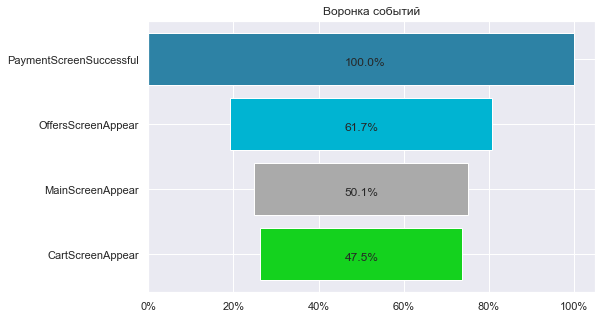

In [93]:
# Визуализируем воронку событий
fig, ax = plt.subplots(figsize=(8,5))
h = funnel['retention'].sort_values()
r = funnel['event_name'].sort_values()
h = np.array(funnel['retention'].sort_values())
colors = ['#14D21E', '#AAAAAA', '#00B4D2', '#2D82A5']

plt.barh(r, width=h, left=(h.max() - h) / 2, align='center', color=colors)

for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_width()), (p.get_x() + p.get_width()/2 - 0.05, p.get_y() + 0.15),
                xytext=(5, 10), textcoords='offset points')
    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    _ = ax.set_xticklabels(map('{:.0f}%'.format, 100*ax.xaxis.get_majorticklocs()))

plt.title("Воронка событий")
plt.show();

Воронка событий выстраивается следующим образом: после открытия главной страницы 61,7% пользователей переходят на страницу с предложением, 50% - доходят до корзины и, наконец, 47,5% успешно оплачивают товар.

Самые большие "потери" в пользователях мы видим при переходе с главной страницы на страницу товара: только 62% из зашедших на первую страницу переходят к следующему этапу. Из тех, кто посмотрел товар примерно 81% кладут его в корзину. И если товар уже в корзине, с вероятностью в 94,7% пользователь его оплачивает. 

Просядание почти в 40% при переходе с главной страницы на страницу товара выглядит довольно существенным. Это значит, что 40% пользователей не находит для себя ничего интересного и уходит без открытия странички с товаром. Возможно, нужно поработать с контентом предварительного представления товара, сделать его более привлекательным и броским, чтобы простимулировать пользователей к более подробному изучению представленных в приложении товаров.   

## **5. Анализ результатов A/A/B тестирования**

В ходе тестирования пользователи были разбиты на 3 группы: 2 контрольные со старыми шрифтами (группы номер 246 и 247) и одну экспериментальную — с новыми (группа номер 248). Цель теста - выяснить, какой шрифт лучше.

При анализе результатов тестирования имеет смысл проверить две метрики. Во-первых, интересно посмотреть, изменилось ли соотношение числа уникальных пользователей, совершивших каждое отдельное событие. Если новый шрифт действительно работает на привлечение пользователей, то мы должны заметить увеличение числа пользователей, переходящих на каждый следующий этап. 
Во-вторых, стоит сопоставить среднее кол-во событий в расчете на одного пользователя в разных группах. Возможно, действие нового шрифта будет проявляться в том, что пользователи будут дольше задерживаться в приложении и, соответственно, среднее число событий на одного пользователя увеличится.  

### **5.1. Оценка результатов А/А теста**

Проверим, исполняются ли у нас критерии успешности A/A-теста:
+ количество пользователей в группах должно различаться не более, чем на 1%;
+ для всех групп фиксируются сопоставимые данные о событиях;
+ различие ключевых метрик по группам не имеет статистической значимости;

In [48]:
# Создадим переменную group_size и проверим кол-во уникальных пользователей в группах
group_size = df.pivot_table(columns='exp_id', values='device_id_hash', aggfunc='nunique')

In [49]:
group_size

exp_id,246,247,248
device_id_hash,2474,2506,2522


In [50]:
(group_size[247].values[0] - group_size[246].values[0])/group_size[246].values[0]

0.012934518997574777

Контрольные группы 246 и 247 примерно равны по размерам (разница в 1.3% находится в допустимых пределах).

In [51]:
# Подсчитаем, сколько уникальных пользователей совершает каждое событие в разбивке по группами
(
    df.pivot_table(index='event_name', columns='exp_id', \
                        values='device_id_hash', aggfunc='nunique')
    .reset_index().sort_values(by=246, ascending=False)
    .style.background_gradient(cmap='Greens', axis=0, low=0.1, high=1)
    .set_properties(subset=[246, 247, 248], **{'width': '80px'})
)

exp_id,event_name,246,247,248
1,MainScreenAppear,2440,2469,2478
2,OffersScreenAppear,1532,1513,1516
0,CartScreenAppear,1256,1231,1215
3,PaymentScreenSuccessful,1190,1151,1166
4,Tutorial,275,283,277


Все наблюдаемые события фиксируются примерно равномерно во всех трех группах. Контрольные группы 246 и 247 имеют небольшие расхождения в частоте распределения событий, однако об их статистической значимости можно будет говорить после проведения z-теста для пропорций. 

Сформулируем нулевую и альтернативную гипотезы.

H0: различий в соотношении кол-ва уникальных пользователей, соверших каждое событие, между группой 246 и группой 247 нет. 

H1: различия в долях есть.

Обозначим уровень статистической значимости: alpha=0.05. Однако учитывая, что нам предстоит провести тестирование по каждому показателю в трех подгруппах (246 и 247, 247 и 248, 246 и 248), применим к обозначенному уровню значимости поправку Бонферрони:
apha = 0.05/3

In [52]:
from statsmodels.stats.proportion import proportions_ztest

Зададим функцию для оценки результатов z-теста для каждого отдельного события.

In [80]:
def proportion_check(group1, group2):

  # Создадим сводную таблицу test_results с результатами экспериментов по группам
  test_results = (df.pivot_table(index='event_name', columns='exp_id', \
                          values='device_id_hash', aggfunc='nunique')
    .sort_values(by=group1, ascending=False)
  )

  # Установим уровень статистической значимости
  alpha = 0.05/3
  
  # Цикл для расчета уровня статистической значимости для каждого события
  for index, row in test_results.iterrows():
    _, p_val = (
        proportions_ztest([row[group1], row[group2]], \
                          [group_size[group1].values[0], \
                          group_size[group2].values[0]])
    )
    print(f'Для события {index}:')
    print(f'p-value: {p_val}')
      
    if (p_val < alpha):
      print("Отвергаем нулевую гипотезу: между группами есть статистически значимая разница")
      print('')
    else:
      print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными")
      print('')

In [81]:
proportion_check(246, 247)

Для события MainScreenAppear:
p-value: 0.7610729163957667
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Для события OffersScreenAppear:
p-value: 0.26218736176825963
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Для события CartScreenAppear:
p-value: 0.2454549210865865
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Для события PaymentScreenSuccessful:
p-value: 0.12493072017288821
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Для события Tutorial:
p-value: 0.8427918367072244
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными



По всем событиям p-value превышает уровень статистической значимости, значит нулевую гипотезу не отвергаем и делаем вывод, что разбиение на контрольные группы сделано корректно.

Проверим теперь, есть ли статистически значимые различия между группами по показателю среднего числа событий на одного пользователя. С помощью метода bootstrap посмотрим сначала на распределение средних выборок по всем трем группам. 

In [55]:
group246 = df.query('exp_id == 246').groupby('device_id_hash')['event_name'].agg('count')
n = 1000
res246 = []
for _ in range(n):
    res246.append(group246.sample(frac=1, replace=True).mean())
    
mean246 = pd.Series(res246)

In [56]:
group247 = df.query('exp_id == 247').groupby('device_id_hash')['event_name'].agg('count')
n = 1000
res247 = []
for _ in range(n):
    res247.append(group247.sample(frac=1, replace=True).mean())
    
mean247 = pd.Series(res247)

In [57]:
group248 = df.query('exp_id == 248').groupby('device_id_hash')['event_name'].agg('count')
n = 1000
res248 = []
for _ in range(n):
    res248.append(group248.sample(frac=1, replace=True).mean())
    
mean248 = pd.Series(res248)

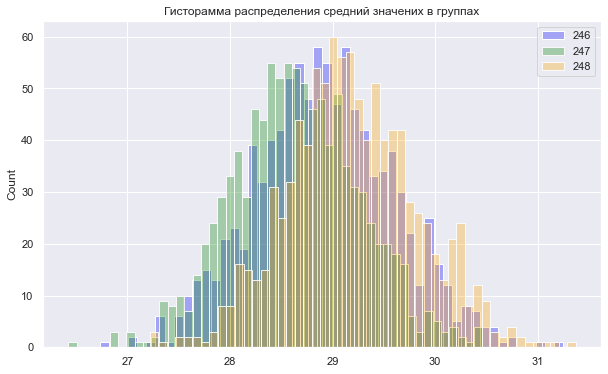

In [59]:
fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(mean246, color='blue', bins=50, alpha=0.3)
sns.histplot(mean247, color='green', bins=50, alpha=0.3)
sns.histplot(mean248, color='orange', bins=50, alpha=0.3)
plt.legend([246, 247, 248])
plt.title('Гисторамма распределения средний значених в группах');

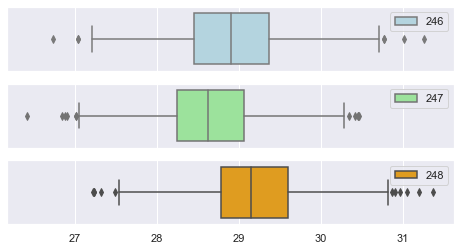

In [79]:
fig, ax = plt.subplots(3, 1, figsize=(8,4), sharex=True)
sns.boxplot(x=mean246.values, color='lightblue', ax=ax[0])
sns.boxplot(x=mean247.values, color='lightgreen', ax=ax[1])
sns.boxplot(x=mean248.values, color='orange', ax=ax[2])
ax[0].legend([246])
ax[1].legend([247])
ax[2].legend([248])

По распределению средних все три группы довольно близки друг к другу. Для подтверждения отсутствия статистических различий между группами 246 и 247 по показателю среднего кол-ва событий используем непараметрический тест Манна-Уитни.

Сформулируем нулевую и альтернативную гипотезы.

H0: различий в среднем кол-ве событий на одного пользователя между группой 246 и группой 247 нет. 

H1: различия в средних показателях есть.

Обозначим уровень статистической значимости (также с поправкой Бонферрони): alpha=0.05/3

In [82]:
# Зададим функцию для оценки статистической значимости разницы средних значений двух групп
def avg_check(group1, group2):
  user_events = df.groupby(['device_id_hash', 'exp_id'])['event_name'].agg('count').reset_index()
  
  print(f'Среднее кол-во событий на пользователя в группе {group1}: ', round(user_events[user_events['exp_id'] == group1]['event_name'].mean(), 1))
  print(f'Среднее кол-во событий на пользователя в группе {group2}: ', round(user_events[user_events['exp_id'] == group2]['event_name'].mean(), 1))

  # Установим уровень статистической значимости
  alpha = 0.05/3
  
  p_val = st.mannwhitneyu(user_events[user_events['exp_id'] == group1]['event_name'], user_events[user_events['exp_id'] == group2]['event_name'])[1]

  print(f'p-value: {p_val}')

  if p_val < alpha:
    print("Отвергаем нулевую гипотезу: между группами есть статистически значимая разница")
  else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными")

In [83]:
avg_check(246, 247)

Среднее кол-во событий на пользователя в группе 246:  28.9
Среднее кол-во событий на пользователя в группе 247:  28.6
p-value: 0.9320179326843641
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными


По средним показателям кол-ва событий на одного пользователя между контрольными группами 246 и 247 различий также не зафиксировано.

### **5.2. Оценка результатов А/В теста**

По тем же самым метрикам сравним результаты контрольных групп и тестовой группы под номером 248. 

Нулевая и альтернативная гипотезы:

H0: различий в соотношении кол-ва уникальных пользователей, соверших каждое событие, между группой 246/247 и группой 248 нет. 

H1: различия в соотношении есть.

Уровень статистической значимости: alpha=0.05/3

In [84]:
proportion_check(246, 248)

Для события MainScreenAppear:
p-value: 0.29108407869663555
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Для события OffersScreenAppear:
p-value: 0.1889674821179712
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Для события CartScreenAppear:
p-value: 0.06694174479858332
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Для события PaymentScreenSuccessful:
p-value: 0.18624034844132686
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Для события Tutorial:
p-value: 0.881484521728291
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными



In [85]:
proportion_check(247, 248)

Для события MainScreenAppear:
p-value: 0.45009892631077086
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Для события OffersScreenAppear:
p-value: 0.8482836962001165
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Для события CartScreenAppear:
p-value: 0.5021725207005302
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Для события PaymentScreenSuccessful:
p-value: 0.8291560168561395
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Для события Tutorial:
p-value: 0.7272001803840037
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными



Во всех случаях p-value выше уровня статистической значимости, значит, у нас нет оснований говорить о наличии каких-либо различий между контрольными группами и тестовой группой по тому, какое кол-во уникальных пользователей приходится на каждое конкретное событие.

Проверим, есть ли различия по показателю среднего кол-ва событий на пользователя.

Нулевая и альтернативная гипотезы:

H0: различий в среднем кол-ве событий на одного пользователя между группами 246/247 и группой 248 нет. 

H1: различия в средних показателях есть.

Уровень статистической значимости: alpha=0.05/3

In [86]:
avg_check(246, 248)

Среднее кол-во событий на пользователя в группе 246:  28.9
Среднее кол-во событий на пользователя в группе 248:  29.2
p-value: 0.4933527658982574
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными


In [87]:
avg_check(247, 248)

Среднее кол-во событий на пользователя в группе 247:  28.6
Среднее кол-во событий на пользователя в группе 248:  29.2
p-value: 0.4324444272284754
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными


По среднему кол-ву событий, приходящихся на одного уникального пользователей, различий между группами также не обнаружено. Среднее кол-во событий на пользователя в группе 248 немного выше, чем в обеих контрольных группах (29.2 против 28.9 и 28.6). Однако статистической значимости эти различия на имеют. 

## **6. Выводы и рекомендации**

**Выводы**

На этапе предварительного анализа имеющихся данных было выявлено, что у нас нет полных данных за весь заявленный период (с 25 июля по 7 августа 2019 года), что вероятно связано с техническими особенностями записей (в логи новых дней по некоторым пользователям могли «доезжать» события из прошлого). Поэтому период исследования был ограничен одной неделей, по которой у нас были наиболее полные данные (с 1 по 7 августа).

Кроме того, при анализе данных были зафиксированы единичные "аномальные" выбросы в виде пользователей, совершивших за указанный период более 300 событий в приложении. Для того чтобы их данные не исказили результатов теста, такие пользователи также были отфильтрованы. Потери при фильтрации данных были несущественными и находились в пределах 1% как по кол-ву пользователей, так и по кол-ву событий.

В общей сложности в эксперименте приняли участие 7551 пользователей, из которых после фильтрации осталось 7534 человек. Проверка показала, что контрольные группы 246 и 247 были разделены корректно.

Анализ результатов A/B тестирования не выявил каких-либо статистически значимых различий в показателях контрольных групп и тестовой группы. Это означает, что введение нового штрифта в приложении никак не влияет на поведенческие паттерны пользователей и не привело к изменению маркетинговых метрик. В тестовой группе мы не наблюдаем ни роста числа уникальных пользователей из расчета на каждое отдельное событие, ни изменение среднего кол-ва событий, приходящихся на одного пользователя. Можно сделать вывод, что новый штрифт не дает ожидаемого эффекта. В то же время стоит отметить, что какого-либо ухудшения показателей в группе, которой показывали страницы с новым шрифтом, зафиксировано также не было.

**Рекомендации**

Основная проблема, которая была выявлена при анализе воронки событий - это значительные "потери" в пользователях при переходе с главной страницы приложения на страницу с товарами - практически 40% пользователей покидает приложение после показа главного экрана и не проявляет интерес к представленной продукции. Для повышения конверсии пользователей между первым и вторым этапом рекомендуется внести изменения в контент главной страницы: пересмотреть номенклатуру представленных в тизере товаров, например, в пользу самых популярных товаров по итогам недельных продаж; повысить качество фотоматериалов, а также разработать более современный и привлекательный дизайн главного экрана.
